# Ripple durations and stimulation
- Load up a sleep session
- Find all canonical ripples
- Plot distribution of all ripple durations
- Find subset of ripples normally detected (set detection threshold to 4 sd above the mean similar to JNE paper recommendation)
- Find subset of ripples that would be detected if we add a temporal threshold

In [1]:
# imports
import numpy as np
import os

import nelpy as nel  
import seaborn as sns
import nelpy.plotting as npl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

/home/shayok/Documents/Code/nelpy_master/nelpy/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
# Shay's plot settings
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Std', font_scale=2, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 10, 'xtick.labelsize': 10}))
%matplotlib inline 

# Load up a sleep session

In [3]:
data = np.loadtxt("/media/shayok/3TBData/Data/RippleDetectionAnalysis/paperData/singleChanAnalysis/dataT2Full.out")
timestamps = np.loadtxt("/media/shayok/3TBData/Data/RippleDetectionAnalysis/paperData/singleChanAnalysis/timeStampsSeconds.out") # seconds

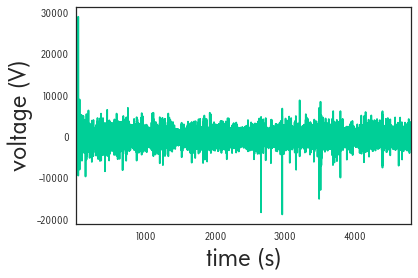

In [14]:
asa = nel.AnalogSignalArray(data,timestamps=timestamps,fs=3000)
npl.plot(asa)

In [15]:
asa

<AnalogSignalArray at 0x7f6b3c74a748: 1 signals> for a total of 1:20:02:807 hours

# Find all canonical ripples

In [16]:
# filter raw data in ripple band
cows = nel.filtering.sosfiltfilt(asa[:,0],fl=150,fh=250,)
# compute envelope of signal
cowy = nel.utils.signal_envelope_1d(cows)
#ripple detection across channels! Defn: 3s.d. above mean for 15ms down to the mean for start and end
ripple_epochs = []
for i,cow in enumerate(cowy.signals):
    #find ripples!
    rippleboundValue = np.std(cow.data.squeeze())+np.mean(cow.data.squeeze())
    ripple_bounds, ripple_maxes, ripple_events = \
                                nel.utils.get_events_boundaries(cow.data, PrimaryThreshold=np.mean(cow.data.squeeze())+(4*np.std(cow.data.squeeze())), \
                                SecondaryThreshold=rippleboundValue,minThresholdLength = 0.015, ds=1/cow.fs)
    #ripple bounds stored as epoch arrays
    ripple_epochs.append(nel.EpochArray((ripple_bounds/cow.fs)+cow.time[0]))
ripple_epochs = ripple_epochs[0]

/home/shayok/Documents/Code/nelpy_master/nelpy/nelpy/utils.py:1225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [17]:
ripple_epochs

<EpochArray at 0x7f6b3c9a44a8: 1,090 epochs> of length 1:18:375 minutes

In [18]:
np.argmin(ripple_epochs.lengths),ripple_epochs.lengths[np.argmin(ripple_epochs.lengths)]

(967, 0.02633333333324117)

In [19]:
np.argmax(ripple_epochs.lengths),ripple_epochs.lengths[np.argmax(ripple_epochs.lengths)]

(510, 0.24166666666678793)

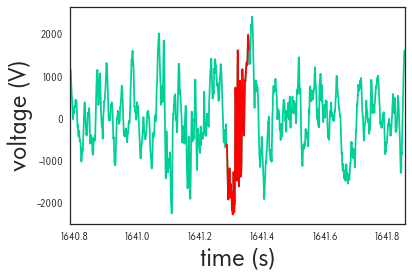

In [20]:
rippleNum = 405
npl.plot(asa[ripple_epochs[rippleNum].expand(0.5)])
npl.plot(asa[ripple_epochs[rippleNum]],color='red')

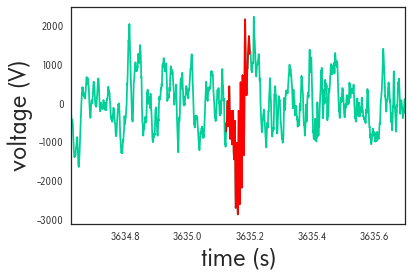

In [24]:
rippleNum = 827
npl.plot(asa[ripple_epochs[rippleNum].expand(0.5)])
npl.plot(asa[ripple_epochs[rippleNum]],color='red')

# Distribution of all ripple durations

Text(0, 0.5, 'Density')

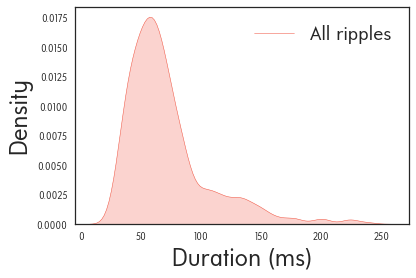

In [26]:
ax = sns.distplot(ripple_epochs.lengths*1000,color=npl.colors.sweet.red,kde=True,hist=False,kde_kws = {'shade': True, 'linewidth': 0.5},label='All ripples')
ax.set_xlabel("Duration (ms)")
ax.set_ylabel("Density")

# Find subset of ripples detected with realtime algorithms

In [28]:
import scipy.signal as signal
def rippleBandFilterSimulated(lfp, time, FS, bpFilterTaps, lpFilterTaps):
    """
    Ripple band filter and envelope simulating real-time algorithm
    """
    #Bandpass filter into ripple band
    rippleData = signal.lfilter(bpFilterTaps,1,lfp)
    #Envelope
    rippleEnvelope = np.absolute(rippleData)
    #smooth
    smoothed_envelope = signal.lfilter(lpFilterTaps,1,rippleEnvelope)
    return smoothed_envelope, rippleData

In [29]:
bandpassFilterTaps=signal.firwin(30, [150,250], nyq=3000/2, pass_zero=False)
#Lowpass FIR Filter Coeffs (After Absolute Value)
lowpassFilterTaps=np.asarray([0.0203770957,
        0.0108532903,
        0.0134954582,
        0.0163441640,
        0.0193546202,
        0.0224738014,
        0.0256417906,
        0.0287934511,
        0.0318603667,
        0.0347729778,
        0.0374628330,
        0.0398648671,
        0.0419196133,
        0.0435752600,
        0.0447894668,
        0.0455308624,
        0.0457801628,
        0.0455308624,
        0.0447894668,
        0.0435752600,
        0.0419196133,
        0.0398648671,
        0.0374628330,
        0.0347729778,
        0.0318603667,
        0.0287934511,
        0.0256417906,
        0.0224738014,
        0.0193546202,
        0.0163441640,
        0.0134954582,
        0.0108532903,
        0.0203770957])

In [30]:
smoothed_envelope, rippleData = rippleBandFilterSimulated(asa[:,-1].data.squeeze(), asa.time, asa.fs, bandpassFilterTaps, lowpassFilterTaps)

In [32]:
len(ripple_epochs)

1090

In [33]:
ripple_bounds.shape # this has the bounds in terms of sample numbers we're going to work with this for detections

(1090, 2)

In [34]:
ripple_bounds[5][0]

110691

In [112]:
# alrighty, i'm going to be super inefficient here and just loop through this crap and do the detections....

# set detection threshold
threshold = 4*np.std(smoothed_envelope) + np.mean(smoothed_envelope)
lockoutperiod = 200 * 3 # samples to skip
lockout = False
lockoutTillSample = -1

detection_latency = []
ripple_detected_normalRules = np.zeros(len(ripple_epochs)) # we're gonna flip these to 1's if the ripple was detected
whichRealRippleWeOn = 0

def checkIfCanonicalRippleDetected(sampleOfDetection, whichRippleWeOn):
    if(whichRippleWeOn>len(ripple_epochs)):
        return [False,whichRippleWeOn,whichRippleWeOn,-1]
    searchRippleBounds = ripple_bounds[whichRippleWeOn]
    # condition: we detected a ripple
    if(sampleOfDetection>=searchRippleBounds[0] and sampleOfDetection<=searchRippleBounds[1]):
        return [True, whichRippleWeOn, whichRippleWeOn+1, sampleOfDetection-searchRippleBounds[0]]
    # condition: we missed "this" ripple
    elif(sampleOfDetection>searchRippleBounds[1]): 
        # we need to search and see if we detected the subsequent ripple
        return checkIfCanonicalRippleDetected(sampleOfDetection,whichRippleWeOn+1)
    #condition: we detected a threshold crossing before "this" ripple
    elif(sampleOfDetection<searchRippleBounds[0]):
        return [False, whichRippleWeOn, whichRippleWeOn,-1]

# normal ripple detection
for i in tqdm(range(len(smoothed_envelope))):
    if(lockout):
        if(i<lockoutTillSample):
            pass
        else:
            lockout = False
    else:
        # check if threshold crossed so ripple detected
        if(smoothed_envelope[i]>threshold):
            lockout = True
            lockoutTillSample = lockoutperiod + i
            # check if there is a cononical ripple here or not
            isdetected, sampleNum, updateWhichRippleWeOn, latency = checkIfCanonicalRippleDetected(i,whichRealRippleWeOn)
            whichRealRippleWeOn = updateWhichRippleWeOn
            if(isdetected):
                ripple_detected_normalRules[sampleNum] = 1
                detection_latency.append(latency)
detection_latency = np.asarray(detection_latency)

In [119]:
# now, let's do the same thing with a temporal req

# set detection threshold
threshold = 3*np.std(smoothed_envelope) + np.mean(smoothed_envelope)
timereq = 10*3 # samples to check if above threshold. first number is the ms above threshold req
timereqSample = -1
lockoutperiod = 200 * 3 # samples to skip
lockout = False
lockoutTillSample = -1

whenWeCrossThreshold = -1
amplitudeThresholdCrossed = False
temporalReqMet = False

detection_latency = []
ripple_detected_tempReq = np.zeros(len(ripple_epochs)) # we're gonna flip these to 1's if the ripple was detected
whichRealRippleWeOn = 0

for i in tqdm(range(len(smoothed_envelope))):
    if(lockout):
        if(i<lockoutTillSample):
            pass
        else:
            lockout = False
    else:
        # check if ripple threshold reqs met
        if(amplitudeThresholdCrossed and temporalReqMet):
            lockout = True
            lockoutTillSample = lockoutperiod + i
            # check if there is a cononical ripple here or not
            isdetected, sampleNum, updateWhichRippleWeOn,latency = checkIfCanonicalRippleDetected(i,whichRealRippleWeOn)
            whichRealRippleWeOn = updateWhichRippleWeOn
            if(isdetected):
                ripple_detected_tempReq[sampleNum] = 1
                detection_latency.append(latency)
            #reset checks
            amplitudeThresholdCrossed = False
            temporalReqMet = False
        # amplitude threshold met but we're waiting on timereq
        elif(amplitudeThresholdCrossed):
            if(smoothed_envelope[i]>threshold and i>=timereqSample):
                temporalReqMet = True
            elif(smoothed_envelope[i]<threshold):
                amplitudeThresholdCrossed = False
        # check if above amplitude threshold
        elif(smoothed_envelope[i]>threshold):
            amplitudeThresholdCrossed = True
            timereqSample = timereq+i
detection_latency = np.asarray(detection_latency)

In [114]:
detection_latency_tempReq40ms = detection_latency/3000

In [116]:
detection_latency_tempReq30ms = detection_latency/3000

In [118]:
detection_latency_tempReq20ms = detection_latency/3000

In [120]:
detection_latency_tempReq10ms = detection_latency/3000

In [63]:
ripple_detected_tempReq_40ms = ripple_detected_tempReq

In [61]:
ripple_detected_tempReq_30ms = ripple_detected_tempReq

In [57]:
ripple_detected_tempReq_20ms = ripple_detected_tempReq

In [59]:
ripple_detected_tempReq_10ms = ripple_detected_tempReq

## Plot subset of ripples detected with real time algorithms

In [90]:
print(np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_10ms==0)]),
np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_20ms==0)]),
np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_30ms==0)]),
np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_40ms==0)]))

0.057999999999992724 0.05266666666648234 0.05366666666668607 0.05766666666659148


In [91]:
print(np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_10ms==1)]),
np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_20ms==1)]),
np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_30ms==1)]),
np.median(ripple_epochs.lengths[np.where(ripple_detected_tempReq_40ms==1)]))

0.06500000000005457 0.06966666666721721 0.07766666666657329 0.09600000000000364


In [93]:
print(len(np.where(ripple_detected_tempReq_10ms==1)[0])/len(ripple_epochs),
len(np.where(ripple_detected_tempReq_20ms==1)[0])/len(ripple_epochs),
len(np.where(ripple_detected_tempReq_30ms==1)[0])/len(ripple_epochs),
len(np.where(ripple_detected_tempReq_40ms==1)[0])/len(ripple_epochs))

0.7504587155963303 0.5568807339449541 0.3743119266055046 0.21009174311926607


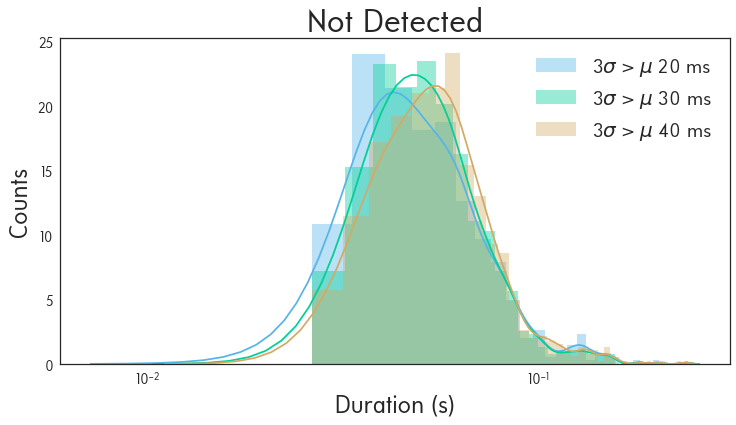

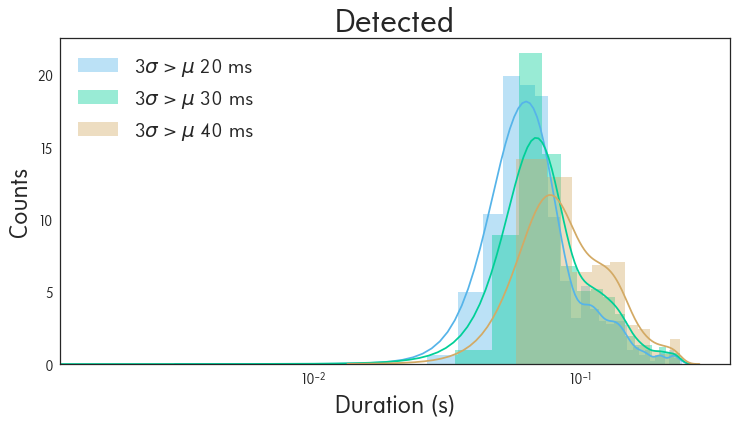

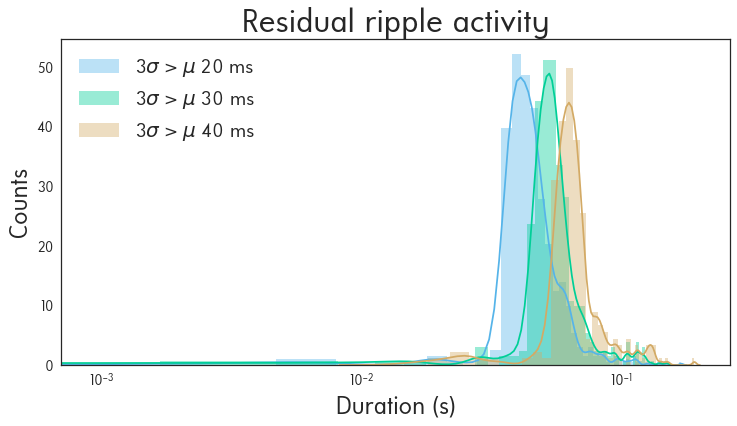

In [135]:
# Shay's plot settings
npl.setup()
npl.set_palette(npl.colors.cows)
npl.setup(font='Universalis ADF Std', font_scale=2, style='white',\
         rc=({'figure.figsize': (12, 6), 'font.size': 18, 'axes.labelsize': 25, \
             'axes.titlesize':33, 'legend.fontsize': 20, 'ytick.labelsize': 15, 'xtick.labelsize': 15}))

# ax = sns.distplot(ripple_epochs.lengths*1000,color=npl.colors.sweet.red,kde=False,hist=True,label='All ripples')
# ax = sns.distplot(ripple_epochs.lengths[np.where(ripple_detected_normalRules==1)[0]]*1000,color=npl.colors.sweet.blue,kde=False,hist=True,label='4 SD above mean detection')
# ax = sns.distplot(ripple_epochs.lengths[np.where(ripple_detected_tempReq==1)[0]]*1000,color=npl.colors.sweet.green,kde=False,hist=True,label='3 SD above mean 20 ms rule')
ax = plt.gca()

# plt.hist(ripple_epochs.lengths[np.where(ripple_detected_normalRules==1)[0]]*1000,color=npl.colors.sweet.blue,label='4 SD above mean detection',alpha=0.5,bins=50)
# plt.hist(ripple_epochs.lengths[np.where(ripple_detected_tempReq==1)[0]],color=npl.colors.sweet.green,label='3$\sigma$ > $\mu$ 20 ms',alpha=0.5,bins=50)

# sns.distplot(np.log10(ripple_epochs.lengths[np.where(ripple_detected_tempReq_10ms==0)[0]]),color=npl.colors.sweet.purple,label='Not detected 3$\sigma$ > $\mu$ 10 ms',kde='True')
sns.distplot((ripple_epochs.lengths[np.where(ripple_detected_tempReq_20ms==0)[0]]),color=npl.colors.sweet.blue,label='3$\sigma$ > $\mu$ 20 ms',kde='True')
sns.distplot((ripple_epochs.lengths[np.where(ripple_detected_tempReq_30ms==0)[0]]),color=npl.colors.sweet.green,label='3$\sigma$ > $\mu$ 30 ms',kde='True')
sns.distplot((ripple_epochs.lengths[np.where(ripple_detected_tempReq_40ms==0)[0]]),color=npl.colors.sweet.gold,label='3$\sigma$ > $\mu$ 40 ms',kde='True')
# sns.distplot(np.log10(ripple_epochs.lengths),color=npl.colors.sweet.red,label="All Ripples",kde='True')
plt.legend()
plt.title("Not Detected")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Counts")
plt.xscale("log")
plt.show()

ax=plt.gca()
sns.distplot((ripple_epochs.lengths[np.where(ripple_detected_tempReq_20ms==1)[0]]),color=npl.colors.sweet.blue,label='3$\sigma$ > $\mu$ 20 ms',kde='True')
sns.distplot((ripple_epochs.lengths[np.where(ripple_detected_tempReq_30ms==1)[0]]),color=npl.colors.sweet.green,label='3$\sigma$ > $\mu$ 30 ms',kde='True')
sns.distplot((ripple_epochs.lengths[np.where(ripple_detected_tempReq_40ms==1)[0]]),color=npl.colors.sweet.gold,label='3$\sigma$ > $\mu$ 40 ms',kde='True')

# plt.hist(ripple_epochs.lengths[np.where(ripple_detected_tempReq_10ms==0)[0]],color=npl.colors.sweet.purple,label='Not detected 3$\sigma$ > $\mu$ 10 ms',alpha=1,bins=50,histtype='step',lw=3)
# plt.hist(ripple_epochs.lengths[np.where(ripple_detected_tempReq_20ms==0)[0]],color=npl.colors.sweet.blue,label='Not detected 3$\sigma$ > $\mu$ 20 ms',alpha=1,bins=50,histtype='step',lw=3)
# plt.hist(ripple_epochs.lengths[np.where(ripple_detected_tempReq_30ms==0)[0]],color=npl.colors.sweet.green,label='Not detected 3$\sigma$ > $\mu$ 30 ms',alpha=1,bins=50,histtype='step',lw=3)
# plt.hist(ripple_epochs.lengths[np.where(ripple_detected_tempReq_40ms==0)[0]],color=npl.colors.sweet.gold,label='Not detected 3$\sigma$ > $\mu$ 40 ms',alpha=1,bins=50,histtype='step',lw=3)
# plt.hist(ripple_epochs.lengths,color=npl.colors.sweet.red,label="All Ripples",alpha=1,bins=50,histtype='step',lw=3)
plt.title("Detected")
plt.xscale("log")
plt.legend()
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Counts")
plt.show()

ax=plt.gca()
sns.distplot(detection_latency_tempReq20ms,color=npl.colors.sweet.blue,label='3$\sigma$ > $\mu$ 20 ms',kde='True')
sns.distplot(detection_latency_tempReq30ms,color=npl.colors.sweet.green,label='3$\sigma$ > $\mu$ 30 ms',kde='True')
sns.distplot(detection_latency_tempReq40ms,color=npl.colors.sweet.gold,label='3$\sigma$ > $\mu$ 40 ms',kde='True')
plt.title("Residual ripple activity")
plt.xscale("log")
plt.legend()
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Counts")
plt.show()